In [1]:
import contractions
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

In [1]:
! pip install tensorflow==2.10.0

  Using cached tensorflow-2.10.0-cp39-cp39-win_amd64.whl (455.9 MB)



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
tf.test.is_built_with_cuda(), tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


(True, False)

In [1]:
import tensorflow as tf

print(tf.__version__)

2.13.0


In [4]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    try:
        # Set memory growth for each GPU
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)

[]


In [2]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
train_data = dataset['train']
train_df = pd.DataFrame(train_data).head(800)

In [4]:
validation_data = dataset['validation']
validation_df = pd.DataFrame(validation_data).head(100)

In [5]:
test_data = dataset['test']
test_df = pd.DataFrame(test_data).head(100)

In [6]:
nltk.download('wordnet')
def preprocess_text(text):
    
    text = text.lower()
    
    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r"[^\w\s]", "", text)

    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    preprocessed_text = ' '.join(tokens)
    
    preprocessed_text = contractions.fix(preprocessed_text)

    return preprocessed_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
train_df['article'] = train_df['article'].apply(preprocess_text)

In [8]:
train_articles = train_df['article'].tolist()
train_summaries = train_df['highlights'].tolist()

In [9]:
test_articles = test_df['article'].tolist()
test_summaries = test_df['highlights'].tolist()

In [10]:
validation_articles = validation_df['article'].tolist()
validation_summaries = validation_df['highlights'].tolist()

In [11]:
train_articles = ['<start> ' + article + ' <end>' for article in train_articles]
train_summaries = ['<start> ' + summary + ' <end>' for summary in train_summaries]

validation_articles = ['<start> ' + article + ' <end>' for article in validation_articles]
validation_summaries = ['<start> ' + summary + ' <end>' for summary in validation_summaries]

test_articles = ['<start> ' + article + ' <end>' for article in test_articles]
test_summaries = ['<start> ' + summary + ' <end>' for summary in test_summaries]

In [12]:
article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(train_articles + validation_articles + test_articles)

summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(train_summaries + validation_summaries + test_summaries)

In [13]:
train_articles_seq = article_tokenizer.texts_to_sequences(train_articles)
train_summaries_seq = summary_tokenizer.texts_to_sequences(train_summaries)

validation_articles_seq = article_tokenizer.texts_to_sequences(validation_articles)
validation_summaries_seq = summary_tokenizer.texts_to_sequences(validation_summaries)

test_articles_seq = article_tokenizer.texts_to_sequences(test_articles)
test_summaries_seq = summary_tokenizer.texts_to_sequences(test_summaries)

In [14]:
article_max_len = 500
summary_max_len = 50

train_articles_seq = pad_sequences(train_articles_seq, maxlen=article_max_len, padding='post')
train_summaries_seq = pad_sequences(train_summaries_seq, maxlen=summary_max_len, padding='post')

In [15]:
validation_articles_seq = pad_sequences(validation_articles_seq, maxlen=article_max_len, padding='post')
validation_summaries_seq = pad_sequences(validation_summaries_seq, maxlen=summary_max_len, padding='post')

In [16]:
test_articles_seq = pad_sequences(test_articles_seq, maxlen=article_max_len, padding='post')
test_summaries_seq = pad_sequences(test_summaries_seq, maxlen=summary_max_len, padding='post')

In [17]:
# Define the input/output shapes and vocabulary size
article_vocab_size = len(article_tokenizer.word_index) + 1 + 2
summary_vocab_size = len(summary_tokenizer.word_index) + 1 + 2
embedding_dim = 128

In [18]:
encoder_inputs = Input(shape=(article_max_len,))
encoder_embedding = Embedding(article_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True)
encoder_outputs1, _, _ = encoder_lstm1(encoder_embedding)
encoder_lstm2 = LSTM(128, return_sequences=True, return_state=True)
encoder_outputs2, _, _ = encoder_lstm2(encoder_outputs1)
encoder_lstm3 = LSTM(128, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs2)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(summary_max_len,))
decoder_embedding = Embedding(summary_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

<center><img src = "markdown_files/pointer_generator.png"></center>

In [19]:
# Attention mechanism
attention = tf.keras.layers.Attention()([decoder_outputs, encoder_outputs])
context_vector = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention])

# Pointer network
pointer_probs = TimeDistributed(Dense(1, activation='sigmoid'))(context_vector)
pointer_probs = tf.keras.layers.Flatten()(pointer_probs)
pointer_probs = tf.keras.layers.RepeatVector(summary_max_len)(pointer_probs)

# Final probabilities
vocab_probs = TimeDistributed(Dense(summary_vocab_size, activation='softmax'))(decoder_outputs)
final_probs = K.concatenate([vocab_probs, pointer_probs], axis=-1)

model = Model([encoder_inputs, decoder_inputs], final_probs)

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 128)     4013056     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 128),   131584      ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [21]:
checkpoint = ModelCheckpoint("seq2seq_pg.h5", period=5, save_weights_only=False, verbose=1)

In [22]:
history = model.fit(
    [train_articles_seq, train_summaries_seq],
    np.expand_dims(train_summaries_seq, axis=-1),
    validation_data=(
        [validation_articles_seq, validation_summaries_seq], 
        np.expand_dims(validation_summaries_seq, axis=-1)),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
13/13 [==============================] - 82s 5s/step - loss: 11.0289 - val_loss: 8.8048
Epoch 2/10
13/13 [==============================] - 57s 4s/step - loss: 8.2147 - val_loss: 7.3879
Epoch 3/10
13/13 [==============================] - 56s 4s/step - loss: 7.1972 - val_loss: 6.4717
Epoch 4/10
13/13 [==============================] - 56s 4s/step - loss: 6.7300 - val_loss: 5.9127
Epoch 5/10
13/13 [==============================] - ETA: 0s - loss: 6.5263
Epoch 5: saving model to seq2seq_pg.h5
13/13 [==============================] - 59s 5s/step - loss: 6.5263 - val_loss: 5.8036
Epoch 6/10
13/13 [==============================] - 58s 4s/step - loss: 6.4794 - val_loss: 5.8604
Epoch 7/10
13/13 [==============================] - 57s 4s/step - loss: 6.4394 - val_loss: 5.8835
Epoch 8/10
13/13 [==============================] - 57s 4s/step - loss: 6.4080 - val_loss: 5.9237


In [23]:
import pickle
with open('article_tokenizer.pickle', 'wb') as handle:
    pickle.dump(article_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
with open('summary_tokenizer.pickle', 'wb') as handle:
    pickle.dump(summary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

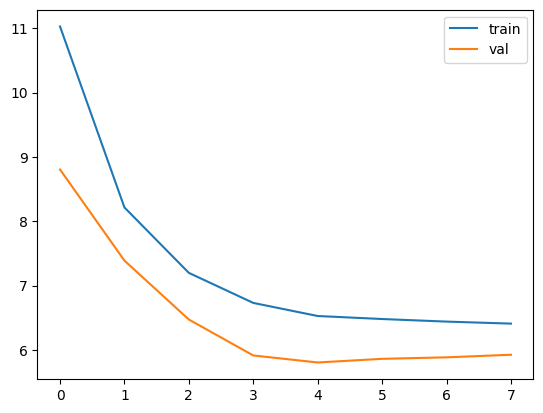

In [25]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [26]:
loss = model.evaluate(
    [test_articles_seq, test_summaries_seq],  # Use the input articles and summaries, excluding the last word
    tf.expand_dims(test_summaries_seq, axis=-1)  # Use the target summaries, excluding the first word
)

print("Test Loss:", loss)

4/4 [==============================] - 3s 689ms/step - loss: 5.9286
Test Loss: 5.928608417510986


In [27]:
article_reverse_word_index=article_tokenizer.index_word
summary_reverse_word_index=summary_tokenizer.index_word

In [28]:
model = load_model('seq2seq_pg.h5')

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 128)     4013056     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 128),   131584      ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [30]:
# Example usage:
articles = [
    """BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was also indicted in the United States along with two other FARC commanders in November 2002 on charges of conspiring to kidnap two U.S. oil workers from neighboring Venezuela in 1997 and holding one of them for nine months until a $1 million ransom was paid. Officials said the army's Rapid Response Force, backed by elements of the Colombian Air Force, tracked Medina Caracas down at a FARC camp in the jungle in the south of the country. "After a bombardment, the troops occupied the camp, and they've found 14 dead rebels so far, along with rifles, pistols, communications equipment and ... four GPS systems," Defense Minister Juan Manuel Santos said at a news conference. "The death of 'El Negro Acacio' was confirmed by various sources, including members of FARC itself." Medina Caracas commanded FARC's 16th Front in the southern departments of Vichada and Guainia. Established in 1964 as the military wing of the Colombian Communist Party, FARC is Colombia's oldest, largest, most capable and best-equipped Marxist rebel group, according to the U.S. Department of State. E-mail to a friend . Journalist Fernando Ramos contributed to this report."""
]

summaries = [
    """Tomas Medina Caracas was a fugitive from a U.S. drug trafficking indictment . "El Negro Acacio" allegedly helped manage extensive cocaine network . U.S. Justice Department indicted him in 2002 . Colombian military: He was killed in an attack on a guerrilla encampment ."""
]

articles = ['<start> ' + article + ' <end>' for article in articles]
summaries = ['<start> ' + summary + ' <end>' for summary in summaries]

In [31]:
def generate_text_predictions(articles, summaries):
    # Convert the texts to sequences
    article_sequences = article_tokenizer.texts_to_sequences(articles)
    article_sequences = pad_sequences(article_sequences, maxlen=500, padding='post')

    summary_sequences = summary_tokenizer.texts_to_sequences(summaries)
    summary_sequences = pad_sequences(summary_sequences, maxlen=50, padding='post')

    # Generate predictions
    predictions = model.predict([article_sequences, summary_sequences])

    # Convert predictions to text format
    prediction_sequences = []
    for pred in predictions:
        pred_indices = np.argmax(pred, axis=-1)
        prediction_sequences.append(pred_indices)

    text_predictions = summary_tokenizer.sequences_to_texts(prediction_sequences)
    
    return text_predictions

predictions = generate_text_predictions(articles, summaries)
for text, summ, pred in zip(articles, summaries, predictions):
    print("Article:", text)
    print("Golden Summary:", summ)
    print("Prediction Summary:", pred)
    print()

1/1 [==============================] - 7s 7s/step
Article: <start> BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers,

In [32]:
encoder_model = Model(encoder_inputs, encoder_states)

In [33]:
# decoder_state_input_h = Input(shape=(128,))
# decoder_state_input_c = Input(shape=(128,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
# decoder_states = [state_h, state_c]
# decoder_dense = TimeDistributed(Dense(summary_vocab_size, activation='softmax')) 
# decoder_outputs = decoder_dense(decoder_outputs)
# decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [34]:
# Define the encoder model from the existing model
encoder_model = Model(encoder_inputs, encoder_states)

# Define the decoder model from the existing model
decoder_inputs_single = Input(shape=(1,))
decoder_embedding_single = Embedding(summary_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs_single)
decoder_outputs_single, state_h_single, state_c_single = decoder_lstm(decoder_embedding_single, initial_state=encoder_states)
decoder_states_single = [state_h_single, state_c_single]
decoder_model = Model([decoder_inputs_single] + encoder_states, [decoder_outputs_single] + decoder_states_single)

In [35]:
# Inputs
decoder_inputs_single = Input(shape=(1,))
encoder_outputs_input = Input(shape=(None, embedding_dim))

# Embedding
decoder_embedding_single = Embedding(summary_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs_single)

# LSTM
decoder_outputs_single, state_h_single, state_c_single = decoder_lstm(
    decoder_embedding_single, 
    initial_state=encoder_states
)
decoder_states_single = [state_h_single, state_c_single]

# Attention
attention_single = tf.keras.layers.Attention()([decoder_outputs_single, encoder_outputs_input])

# Context Vector
context_vector_single = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs_single, attention_single])

# Pointer network
# Pointer network
pointer_probs_single = TimeDistributed(Dense(1, activation='sigmoid'))(context_vector_single)
pointer_probs_single = tf.squeeze(pointer_probs_single, axis=-1)

# Final probabilities
vocab_probs_single = tf.keras.layers.Dense(summary_vocab_size, activation='softmax')(decoder_outputs_single)
# final_probs_single = K.concatenate([vocab_probs_single, pointer_probs_single], axis=-1)

# Define the decoder model from the existing model
decoder_model = Model(
    [decoder_inputs_single] + encoder_states, 
    [vocab_probs_single] + decoder_states_single
)

In [36]:
# def decode_sequence(input_seq):
#     # Encode the input as state vectors.
#     states_value = encoder_model.predict(input_seq)

#     # Generate empty target sequence of length 1.
#     target_seq = np.zeros((1,1))

#     # Populate the first character of target sequence with the start character.
#     target_seq[0, 0] = article_tokenizer.word_index['start']

#     # Sampling loop for a batch of sequences
#     stop_condition = False
#     decoded_sentence = ''

#     while not stop_condition:
#         output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

#         # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_char = article_tokenizer.index_word[sampled_token_index]

#         # Exit condition: either hit max length or find stop token.
#         if sampled_char == 'end' or len(decoded_sentence.split()) > summary_max_len:
#             stop_condition = True
#             continue
#         else:
#             decoded_sentence += ' '+sampled_char

#         # Update the target sequence (of length 1).
#         target_seq = np.zeros((1,1))
#         target_seq[0, 0] = sampled_token_index

#         # Update states
#         states_value = [h, c]

#     return decoded_sentence

# # Predict on new texts

# article_sequences = article_tokenizer.texts_to_sequences(preprocess_text(articles[0]))
# article_sequences = pad_sequences(article_sequences, maxlen=article_max_len)

    
# print('Input text:', articles[0])
# print('Generated Summary:', decode_sequence(article_sequences.reshape(1, -1)))
# print("Summary:", summaries[0])

Input text: <start> BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States

ValueError: in user code:

    File "f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 500), found shape=(None, 803000)


In [ ]:
# import numpy as np
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import load_model

# def generate_text_predictions(articles, summaries):
#     model = load_model('text_generation_model.h5')  # Load the trained model
#     summary_tokenizer = Tokenizer()  # Create a new tokenizer for the summaries
#     summary_tokenizer.fit_on_texts(summaries)  # Fit the tokenizer on the summary texts
#     text_predictions = []

#     for article in articles:
#         sequences = summary_tokenizer.texts_to_sequences([article])  # Convert article text to sequences
#         input_data = pad_sequences(sequences, maxlen=1000)  # Pad the input sequence
#         pred = model.predict(input_data)  # Generate predictions
#         pred_indices = np.argmax(pred, axis=-1)
#         pred_indices_list = pred_indices.tolist()  # Convert numpy array to list
#         pred_text = summary_tokenizer.sequences_to_texts(pred_indices_list)
#         text_predictions.append(pred_text)

#     return text_predictions

# # Example usage
# articles = [
#     """BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was also indicted in the United States along with two other FARC commanders in November 2002 on charges of conspiring to kidnap two U.S. oil workers from neighboring Venezuela in 1997 and holding one of them for nine months until a $1 million ransom was paid. Officials said the army's Rapid Response Force, backed by elements of the Colombian Air Force, tracked Medina Caracas down at a FARC camp in the jungle in the south of the country. "After a bombardment, the troops occupied the camp, and they've found 14 dead rebels so far, along with rifles, pistols, communications equipment and ... four GPS systems," Defense Minister Juan Manuel Santos said at a news conference. "The death of 'El Negro Acacio' was confirmed by various sources, including members of FARC itself." Medina Caracas commanded FARC's 16th Front in the southern departments of Vichada and Guainia. Established in 1964 as the military wing of the Colombian Communist Party, FARC is Colombia's oldest, largest, most capable and best-equipped Marxist rebel group, according to the U.S. Department of State. E-mail to a friend . Journalist Fernando Ramos contributed to this report."""
# ]

# summaries = [
#     """Tomas Medina Caracas was a fugitive from a U.S. drug trafficking indictment . "El Negro Acacio" allegedly helped manage extensive cocaine network . U.S. Justice Department indicted him in 2002 . Colombian military: He was killed in an attack on a guerrilla encampment ."""
# ]

# predictions = generate_text_predictions(articles, summaries)

# for text, summ, pred in zip(articles, summaries, predictions):
#     print("Article:", text)
#     print("Summary:", summ)
#     print("Predicted Summary:", pred)
#     print()


In [39]:
def summarize(article):
    print(f"Preprocessed article: {article}")
    
    # Convert the article to a sequence
    sequence = article_tokenizer.texts_to_sequences([article])
    print(f"Sequence: {sequence}")
    
    # Pad the sequence
    sequence = pad_sequences(sequence, maxlen=article_max_len, padding='post')
    print(f"Padded sequence: {sequence}")
    
    # Get the initial encoder states
    initial_states = encoder_model.predict(sequence)
    print(f"Initial states: {initial_states}")
    
    # Create an array to hold the generated summary
    generated_summary = []
    
    # The first input to the decoder is always the '<start>' token
    current_word = article_tokenizer.word_index['start']
    current_word = [current_word]
    current_word = np.array([current_word])
    current_word = np.expand_dims(current_word, 1)
    
    # Continue generating words until '<end>' token is generated or max length is reached
    for i in range(summary_max_len):
        # Get the next word probabilities and next states
        probs, h, c = decoder_model.predict([current_word] + initial_states)
        print(f"Next word probabilities: {probs}")
        print(f"Next states: {[h, c]}")
        
        # Get the index of the word with the highest probability
        next_word = np.argmax(probs[0, 0, :])
        print(f"Next word: {next_word} ({article_tokenizer.index_word.get(next_word, '?')})")
        
        # If the next word is the '<end>' token, stop generating
        if next_word == article_tokenizer.word_index['end']:
            break
        
        # Otherwise, add the next word to the generated summary
        generated_summary.append(article_tokenizer.index_word[next_word])
        
        # Update the current word and initial states
        current_word = np.array([next_word])
        current_word = np.expand_dims(current_word, 1)

        initial_states = [h, c]
    
    # Return the generated summary as a string
    return ' '.join(generated_summary)


In [40]:
summarize(preprocess_text(articles[0]))

Preprocessed article: start bogota colombia cnn key rebel commander fugitive us drug trafficking indictment killed weekend air attack guerrilla encampment colombian military said monday alleged cocaine trafficker farc rebel tomas medina caracas interpol photo tomas medina caracas known popularly el negro acacio member high command fuerzas armadas revolucionarias de colombia according colombian us officials helped manage groups extensive cocaine trafficking network crosshairs us justice department since charged conspiracy import cocaine united states manufacturing distributing cocaine within colombia fund farcs year insurgency government us officials alleged medina caracas managed rebel groups sales cocaine international drug traffickers turn smuggled united states also indicted united states along two farc commanders november charges conspiring kidnap two us oil workers neighboring venezuela holding one nine months million ransom paid officials said armys rapid response force backed el

'vince vince vince stays stays stays stays stays stays stays stays caller caller caller caller caller caller caller caller reserves reserves reserves reserves reserves fighters examiners examiners davenport davenport davenport davenport davenport detained detained detained detained detained detained detained detained detained detained detained detained detained detained detained detained detained detained'